In [36]:
import numpy as np, pandas as pd, scipy.stats as stats, matplotlib.pyplot as plt, matplotlib.mlab as mlab,seaborn as sns
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import xgboost as xgb
from math import sqrt

In [48]:
#read data
data = pd.read_csv('C:/Users/23721/my_py_file/BTC/文件1.样本训练数据.csv',encoding='gbk')
data.head()

,ID,时间,开盘价,收盘价,最高价,最低价,成交额,成交笔数
0,1514736000,2018/1/1 0:00,13249.25,13248.46,13285.27,13246.74,117361.06160,109
1,1514736060,2018/1/1 0:01,13277.24,13296.44,13296.70,13269.82,83540.28347,124
2,1514736120,2018/1/1 0:02,13296.19,13305.95,13328.00,13271.14,94607.05657,141
3,1514736180,2018/1/1 0:03,13305.98,13340.71,13375.01,13305.96,221544.66270,219
4,1514736240,2018/1/1 0:04,13340.72,13420.00,13420.00,13340.71,173243.59680,230


In [49]:
#ID is useless
data.drop('ID',axis=1,inplace=True)


In [50]:
#create new feature '成交量' = 成交额/mean of 收盘价 and 开盘价 since the price will influence volume
data['成交量']=data['成交额']/((data['收盘价']+data['开盘价'])/2)

In [51]:
#get return(log form) function
def get_return(df):
    df['return'] = 0
    df['return'][1:]= np.log(df['收盘价'][1:].to_numpy()/df['收盘价'][:-1].to_numpy())
    df.drop(index=df.index[0],inplace = True)


In [53]:
#get return
min_1 = data.copy(deep=True)
get_return(min_1)
min_1.head()

<ipython-input-51-c48a61665c5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'][1:]= np.log(df['收盘价'][1:].to_numpy()/df['收盘价'][:-1].to_numpy())
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,时间,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return
1,2018/1/1 0:01,13277.24,13296.44,13296.70,13269.82,83540.28347,124,6.287446,0.003615
2,2018/1/1 0:02,13296.19,13305.95,13328.00,13271.14,94607.05657,141,7.112740,0.000715
3,2018/1/1 0:03,13305.98,13340.71,13375.01,13305.96,221544.66270,219,16.628306,0.002609
4,2018/1/1 0:04,13340.72,13420.00,13420.00,13340.71,173243.59680,230,12.947604,0.005926
5,2018/1/1 0:05,13420.00,13488.00,13490.00,13400.83,142241.98580,256,10.572468,0.005054


In [142]:
def statistics(close):
    mc = np.mean(close)
    stdc = np.std(close)
    print({'mean':mc,'median':np.median(close),'std':stdc,'skewness':stats.skew(close),'kurtosis':stats.kurtosis(close)})
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='BTC')
    plt.plot(x,y,color='black',label='Normal')
    plt.show()


{'mean': -2.3990422149736325e-06, 'median': 0.0, 'std': 0.0012391892049649583, 'skewness': 0.3730242032561778, 'kurtosis': 20.511265739643193}


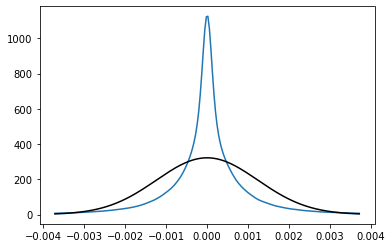

In [143]:
#compare with normal distribution and then found strong leptokurtosis
statistics(min_1['return'])

In [54]:
#repeat for 1h interval
h_1 = min_1.copy()
h_1 .head(61)

,时间,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return
1,2018/1/1 0:01,13277.24,13296.44,13296.70,13269.82,83540.28347,124,6.287446,0.003615
2,2018/1/1 0:02,13296.19,13305.95,13328.00,13271.14,94607.05657,141,7.112740,0.000715
3,2018/1/1 0:03,13305.98,13340.71,13375.01,13305.96,221544.66270,219,16.628306,0.002609
4,2018/1/1 0:04,13340.72,13420.00,13420.00,13340.71,173243.59680,230,12.947604,0.005926
5,2018/1/1 0:05,13420.00,13488.00,13490.00,13400.83,142241.98580,256,10.572468,0.005054
...,...,...,...,...,...,...,...,...,...
57,2018/1/1 0:57,13924.64,13921.27,13947.62,13901.53,98814.01510,123,7.097201,0.000006
58,2018/1/1 0:58,13928.52,13901.55,13928.52,13901.55,31565.10521,29,2.268417,-0.001418
59,2018/1/1 0:59,13901.55,13913.37,13925.95,13900.00,88754.48260,58,6.381790,0.000850
60,2018/1/1 1:00,13902.75,13900.00,13913.31,13900.00,107899.04630,90,7.761754,-0.000961


In [56]:
#group by hours
h_1['时间']=pd.to_datetime(h_1['时间'])
h_1 = h_1.set_index('时间')
h_1['volatility'] = h_1['return']
h_1.head()

,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return,volatility
时间,,,,,,,,,
2018-01-01 00:01:00,13277.24,13296.44,13296.70,13269.82,83540.28347,124,6.287446,0.003615,0.003615
2018-01-01 00:02:00,13296.19,13305.95,13328.00,13271.14,94607.05657,141,7.112740,0.000715,0.000715
2018-01-01 00:03:00,13305.98,13340.71,13375.01,13305.96,221544.66270,219,16.628306,0.002609,0.002609
2018-01-01 00:04:00,13340.72,13420.00,13420.00,13340.71,173243.59680,230,12.947604,0.005926,0.005926
2018-01-01 00:05:00,13420.00,13488.00,13490.00,13400.83,142241.98580,256,10.572468,0.005054,0.005054


In [57]:
#aggregation
aggregation = {'开盘价': 'first', '收盘价': 'last','最高价':'max','最低价':'min',
               '成交额':'sum','成交笔数':'sum','成交量':'sum','return':'sum','volatility':'std'}
h_1 = h_1.resample('H').agg(aggregation)
h_1['index']=np.exp(np.cumsum(h_1['return']))*100
h_1.head()

,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return,volatility,index
时间,,,,,,,,,,
2018-01-01 00:00:00,13277.24,13913.37,14050.00,13269.82,1.126741e+07,10331,819.324766,0.048969,0.002697,105.018772
2018-01-01 01:00:00,13902.75,13798.00,13913.31,13676.07,5.412145e+06,4363,391.923575,-0.008327,0.001490,104.147954
2018-01-01 02:00:00,13798.00,13710.62,13857.70,13698.75,2.945100e+06,2037,213.711143,-0.006353,0.000909,103.488405
2018-01-01 03:00:00,13720.91,13814.68,13888.00,13697.69,2.589709e+06,1563,187.599016,0.007561,0.001051,104.273855
2018-01-01 04:00:00,13817.61,13966.95,14050.00,13816.38,3.429175e+06,1656,246.136546,0.010962,0.001303,105.423196


{'mean': -0.00014394225903515637, 'median': 1.712740001033364e-05, 'std': 0.009786697279985455, 'skewness': 0.3021309859966892, 'kurtosis': 12.57404056871935}


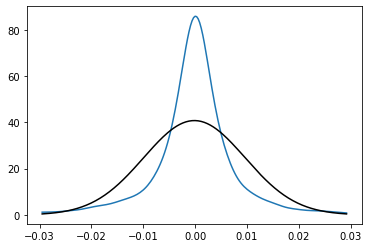

In [17]:
#also lepokurtosis
statistics(h_1['return'])

In [18]:
#create pivot table for plot
df = data.copy()
df['日期']=df['时间']
df['日期']=list(map(lambda x: x.split()[0],df['日期']))
df['时间']=list(map(lambda x: x.split()[1],df['时间']))
pivot = pd.pivot_table(df,index=["时间"],values=['成交量'],columns=['日期'])

Text(0.5, 0, 'days')

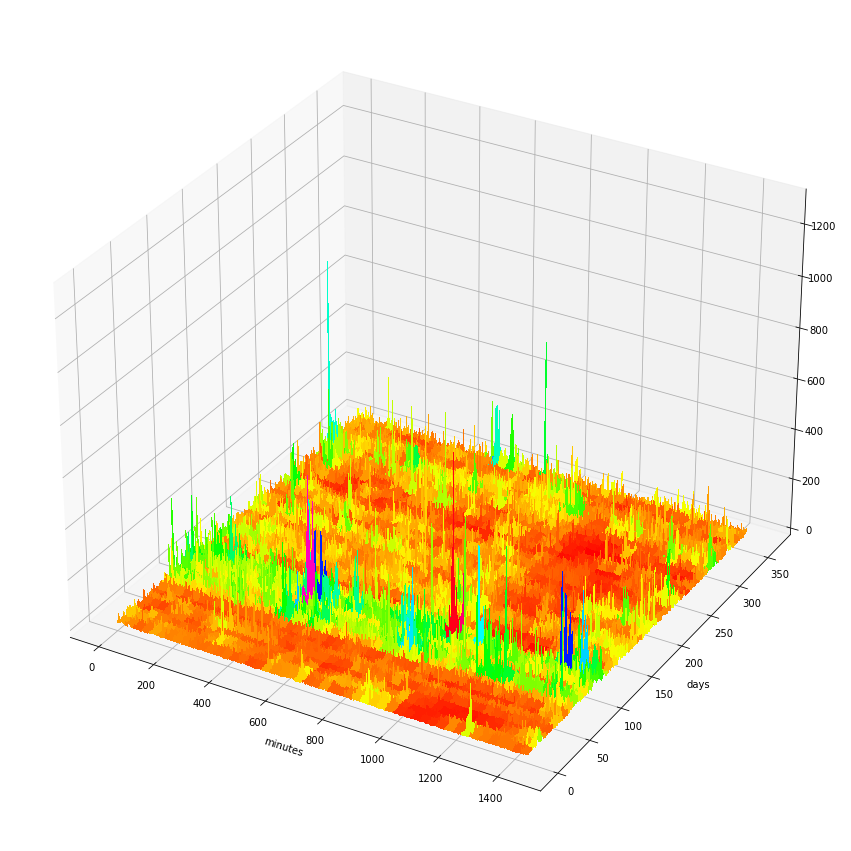

In [19]:
#3D surface plot to find if any volume signal exist
y = list(range(len(pivot.index)))
x = list(range(len(pivot.columns)))
y,x=np.meshgrid(x,y)
z = pivot.to_numpy()
fig = plt.figure(figsize=(15,20))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z,cmap=cm.hsv,
                       linewidth=0, antialiased=False)
ax.set_xlabel("minutes")
ax.set_ylabel("days")


Text(0.5, 0, 'days')

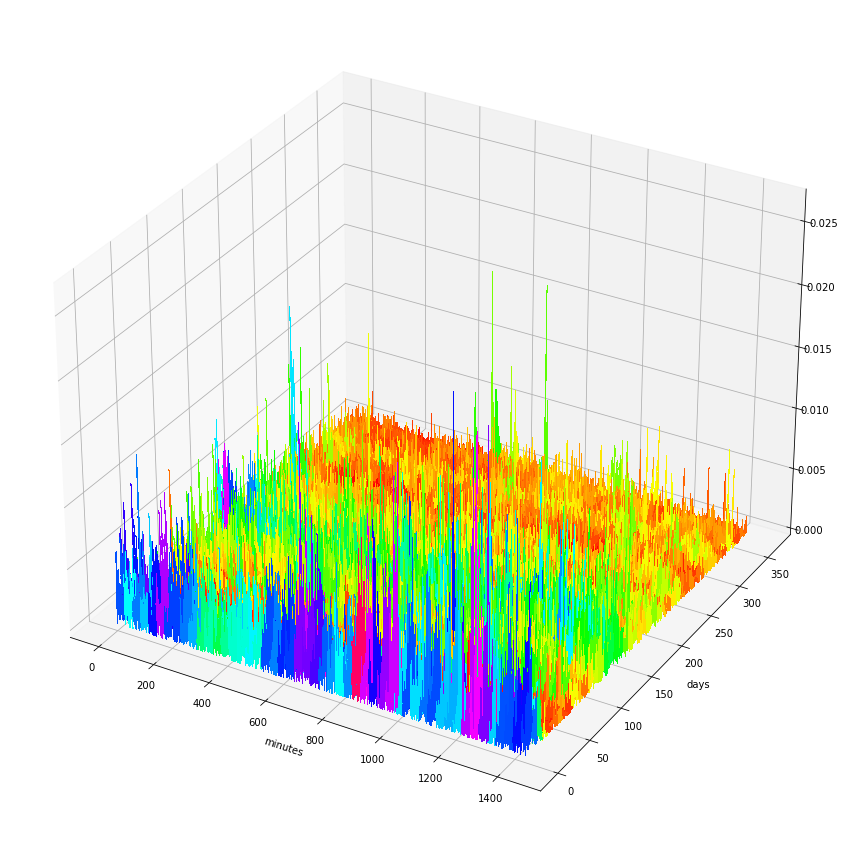

In [20]:
#next 3d plot for returns
df = min_1.copy()
df['日期']=df['时间']
df['abs_return']=abs(df['return'])
df['日期']=list(map(lambda x: x.split()[0],df['日期']))
df['时间']=list(map(lambda x: x.split()[1],df['时间']))
pivot = pd.pivot_table(df,index=["时间"],values=['abs_return'],columns=['日期'],fill_value=0)
y = list(range(len(pivot.index)))
x = list(range(len(pivot.columns)))
y,x=np.meshgrid(x,y)
z = pivot.to_numpy()
fig = plt.figure(figsize=(15,20))
ax = fig.gca(projection='3d')
ax.plot_surface(x,y,z,cmap=cm.hsv,
                       linewidth=0, antialiased=False)
ax.set_xlabel("minutes")
ax.set_ylabel("days")


In [556]:
#CTA Dual Thrust strategy

def dt_basic(df,n=10,k1=0.5,k2=0.4):
    cta = df.copy()
    cash=100
    position = [100]
    re = []
    holding = 0
    oldposition = 0
    h = [0]
    for i in range(len(cta)-n):
        HH=max(cta['最高价'][i:(i+n)])
        LC=min(cta['收盘价'][i:(i+n)])
        HC=max(cta['收盘价'][i:(i+n)])
        LL=max(cta['最低价'][i:(i+n)])
        r=max(HH-LC,HC-LL)
        if(cta['最高价'][i+n]>(cta['开盘价'][i+n]+r*k1) and (holding==0)):           
            holding = cash/cta['收盘价'][i+n]
            cash = 0
            buy=i
        elif((holding!=0) and (cta['最低价'][i+n]<(cta['开盘价'][i+n]-r*k2))):
            cash = holding*cta['收盘价'][i+n]
            holding = 0
        h.append(int(holding>0))
        position.append(holding*cta['收盘价'][i+n]+cash)
        re.append(np.log(position[i+1]/position[i]))
    cta.drop(cta.index[:n],inplace=True)
    cta['NAV'] = position[1:]
    cta['position'] = h[:-1]
    cta['return'] = re
    return(cta[['NAV','position','return']])


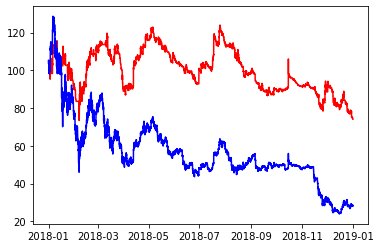

In [557]:
#plot for NAV changes
dt1 = dt_basic(h_1)
plt.plot(dt1['NAV'],color='r')
plt.plot(h_1['index'],color='b')

In [378]:
#Sharpe ratio
def sharpe(df):
    rf = 0.03
    return((np.sum(df['return'])-len(df)/24/365*rf)/(np.std(df['return'])*len(df)**0.5))

In [ ]:
sharpe(dt1)

In [ ]:
#test for different parameters
k1test = np.arange(0.5,3.1,0.5)
k2test = np.arange(0.5,2.6,0.5)
ntest = np.array([4,12,24,48,72,96])

In [410]:
#maxdrawdown
def maxdrawdown(r):
    down = 0
    maxdrawdown = 0
    for i in r:
        if i<0:
            down=i+down
        else:
            maxdrawdown=min(down,maxdrawdown)
            down = 0
    return(1-np.exp(maxdrawdown))


In [ ]:
#find best parameters
sh=[]
re=[]
md=[]
for k1 in k1test:
    for k2 in k2test:
        for n in ntest:
            dtt = dt_basic(h_1,n=n,k1=k1,k2=k2)
            sh.append(sharpe(dtt))
            re.append(np.mean(dtt['return'])*365*24)
            md.append(maxdrawdown(dtt['return']))
            
        print(k2)
tests = np.array(sh).reshape(len(k1test),len(k2test),len(ntest))
testr = np.array(re).reshape(len(k1test),len(k2test),len(ntest))
testmd = np.array(md).reshape(len(k1test),len(k2test),len(ntest))


In [ ]:
#heatmap for sharpe ratio
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(tests[:,:,0],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=4")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(tests[:,:,1],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=12")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(tests[:,:,2],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=24")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(tests[:,:,3],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=48")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(tests[:,:,4],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=72")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(tests[:,:,5],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=1.2,vmin=-1.5)
plt.title("sharpe when n=96")

In [ ]:
#heatmap for total return
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(testr[:,:,0],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=4")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(testr[:,:,1],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=12")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(testr[:,:,2],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=24")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(testr[:,:,3],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=48")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(testr[:,:,4],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=72")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(testr[:,:,5],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.4,vmin=-2)
plt.title("return when n=96")

In [ ]:
#heatmap for maxdrawdown
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(testmd[:,:,0],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=4")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(testmd[:,:,1],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=12")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(testmd[:,:,2],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=24")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(testmd[:,:,3],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=48")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(testmd[:,:,4],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=72")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(testmd[:,:,5],index=k1test, columns=[round(i,2) for i in k2test]),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when n=96")

In [ ]:
#plot NAV for strategies with different parameters
f= plt.figure(figsize=(18,12))
f.add_subplot(221)
dtt = dt_basic(h_1,n=24,k1=1.5,k2=0.5)
plt.plot(dtt['NAV'],color='r',label='dt')
plt.plot(h_1['index'],color='b',label='BTC index')
plt.legend()
plt.title('24h k1=1.5 k2=0.5')

f.add_subplot(222)
dtt = dt_basic(h_1,n=24,k1=1,k2=1)
plt.plot(dtt['NAV'],color='r',label='dt')
plt.plot(h_1['index'],color='b',label='BTC index')
plt.legend()
plt.title('24h k1=1 k2=1')

f.add_subplot(223)
dtt = dt_basic(h_1,n=48,k1=1.5,k2=0.5)
plt.plot(dtt['NAV'],color='r',label='dt')
plt.plot(h_1['index'],color='b',label='BTC index')
plt.legend()
plt.title('48h k1=1.5 k2=0.5')

f.add_subplot(224)
dtt = dt_basic(h_1,n=48,k1=0.5,k2=1)
plt.plot(dtt['NAV'],color='r',label='dt')
plt.plot(h_1['index'],color='b',label='BTC index')
plt.legend()
plt.title('48h k1=0.5 k2=1')

In [435]:
#extra dt strategy
def dt_v1(df,n=10,k1=0.5,k2=0.4,k3=0.05):
    cta = df.copy()
    cash=100
    position = [100]
    re = []
    holding = 0
    oldposition = 0
    h = [0]
    for i in range(len(cta)-n):
        HH=max(cta['最高价'][i:(i+n)])
        LC=min(cta['收盘价'][i:(i+n)])
        HC=max(cta['收盘价'][i:(i+n)])
        LL=max(cta['最低价'][i:(i+n)])
        r=max(HH-LC,HC-LL)
        if(cta['最高价'][i+n]>(cta['开盘价'][i+n]+r*k1) and (holding==0)):           
            holding = cash/cta['收盘价'][i+n]
            cash = 0
            buy=i
        elif((holding!=0) and ((cta['最低价'][i+n]<(cta['开盘价'][i+n]-r*k2)) or (sum(re[buy:])>k3))):
            cash = holding*cta['收盘价'][i+n]
            holding = 0
        h.append(int(holding!=0))
        position.append(holding*cta['收盘价'][i+n]+cash)
        re.append(np.log(position[i+1]/position[i]))
    cta.drop(cta.index[:n],inplace=True)
    cta['NAV'] = position[1:]
    cta['position'] = h[:-1]
    cta['return'] = re
    return(cta[['NAV','position','return']])


In [ ]:
#try nrew strategy
k1test=[round(i,2) for i in np.arange(0.3,1.2,0.1)]
k2test=[round(i,2) for i in np.arange(0.3,1,0.1)]
k3test=[round(i,2) for i in np.arange(0.01,0.07,0.01)]
sh=[]
re=[]
md=[]
tr=[]
for k1 in k1test:
    for k2 in k2test:
        for k3 in k3test:
            dtt = dt_v1(h_1,n=48,k1=k1,k2=k2,k3=k3)
            sh.append(sharpe(dtt))
            re.append(np.mean(dtt['return'])*365*24)
            md.append(maxdrawdown(dtt['return']))
            tr.append(sum(abs(dtt['trade']))/2)
        print(k2)
testsn = np.array(sh).reshape(len(k1test),len(k2test),len(k3test))
testrn = np.array(re).reshape(len(k1test),len(k2test),len(k3test))
testmdn = np.array(md).reshape(len(k1test),len(k2test),len(k3test))
testtr = np.array(tr).reshape(len(k1test),len(k2test),len(k3test))

In [ ]:
#heatmap for sharpe ratio
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(testsn[:,:,0],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.01")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(testsn[:,:,1],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.02")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(testsn[:,:,2],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.03")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(testsn[:,:,3],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.04")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(testsn[:,:,4],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.05")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(testsn[:,:,5],index=k1test, columns=k2test),annot=True,vmax=1.5,vmin=-1)
plt.title("sharpe when k3=0.06")


In [ ]:
#heatmap for return
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(testrn[:,:,0],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.01")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(testrn[:,:,1],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.02")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(testrn[:,:,2],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.03")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(testrn[:,:,3],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.04")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(testrn[:,:,4],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.05")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(testrn[:,:,5],index=k1test, columns=k2test),annot=True,vmax=0.4,vmin=-1)
plt.title("return when k3=0.06")

In [ ]:
#heatmap for return
f= plt.figure(figsize=(18,12))
f.add_subplot(231)
sns.heatmap(pd.DataFrame(testmdn[:,:,0],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.01")
f.add_subplot(232)
sns.heatmap(pd.DataFrame(testmdn[:,:,1],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.02")
f.add_subplot(233)
sns.heatmap(pd.DataFrame(testmdn[:,:,2],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.03")
f.add_subplot(234)
sns.heatmap(pd.DataFrame(testmdn[:,:,3],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.04")
f.add_subplot(235)
sns.heatmap(pd.DataFrame(testmdn[:,:,4],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.05")
f.add_subplot(236)
sns.heatmap(pd.DataFrame(testmdn[:,:,5],index=k1test, columns=k2test),annot=True,vmax=0.15,vmin=0.05)
plt.title("maxdrawdown when k3=0.06")

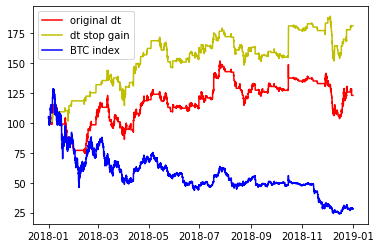

In [436]:
#plot for new strategy and old one with index
dtt=dt_basic(h_1,k1=0.3,k2=0.3,n=48)
dtv1 = dt_v1(h_1,k1=0.3,k2=0.3,n=48,k3=0.02)
plt.plot(dtt['NAV'],color='r',label='original dt')
plt.plot(dtv1['NAV'],color='y',label='dt stop gain')
plt.plot(h_1['index'],color='b',label='BTC index')
plt.legend()

In [512]:
#ML data preparation
mldata = h_1.copy()
mldata.drop('index',axis=1,inplace=True)
mldata.head()

,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return,volatility
时间,,,,,,,,,
2018-01-01 00:00:00,13277.24,13913.37,14050.00,13269.82,1.126741e+07,10331,819.324766,0.048969,0.002697
2018-01-01 01:00:00,13902.75,13798.00,13913.31,13676.07,5.412145e+06,4363,391.923575,-0.008327,0.001490
2018-01-01 02:00:00,13798.00,13710.62,13857.70,13698.75,2.945100e+06,2037,213.711143,-0.006353,0.000909
2018-01-01 03:00:00,13720.91,13814.68,13888.00,13697.69,2.589709e+06,1563,187.599016,0.007561,0.001051
2018-01-01 04:00:00,13817.61,13966.95,14050.00,13816.38,3.429175e+06,1656,246.136546,0.010962,0.001303


In [513]:
#add extra former 24h data
def h_24(df):
    mldata=df.copy()
    o_24=[]
    h_24=[]
    l_24=[]
    c_24=[]
    volume_24=[]
    volatility_24=[]
    for i in range(len(mldata)-25):
        o_24.append(np.log(mldata['开盘价'][i+1]/mldata['收盘价'][i]))
        h_24.append(np.log(max(mldata['最高价'][(i+1):(i+25)])/mldata['收盘价'][i]))
        l_24.append(np.log(min(mldata['最低价'][(i+1):(i+25)])/mldata['收盘价'][i]))
        c_24.append(np.log(mldata['收盘价'][(i+25)]/mldata['收盘价'][i]))
        volume_24.append(sum(mldata['成交量'][(i+1):(i+25)]))
        volatility_24.append(np.std(mldata['return'][(i+1):(i+25)]))
    d=np.log(mldata[['开盘价','收盘价','最低价','最高价']].to_numpy()[1:,:]
                                                        /np.repeat(mldata['收盘价'].to_numpy()[:-1],4).reshape(len(mldata)-1,4))
    mldata['return_s']=mldata['return'].shift(-1)
    mldata.drop(index=mldata.index[0],inplace=True)
    mldata[['开盘价','收盘价','最低价','最高价']]=d

    mldata.drop(mldata.index[:24],inplace=True)
    mldata['o_24']=o_24
    mldata['h_24']=h_24
    mldata['l_24']=l_24
    mldata['h_24']=h_24
    mldata['c_24']=c_24
    mldata['volume_24']=volume_24
    mldata['volatility_24']=volatility_24

    mldata[['成交量','volume_24']]=mldata[['成交量','volume_24']].shift(1)/mldata[['成交量','volume_24']]

    mldata.drop(index=mldata.index[[0,-1]],inplace=True)
    mldata.drop(['成交额','return','成交笔数'],axis=1,inplace=True)
    mldata[['成交量','volume_24']]=np.log(mldata[['成交量','volume_24']])
    mldata.fillna(0,inplace=True)
    return(mldata)

mldata = h_24(mldata)
mldata.head()

<ipython-input-513-850716fb1a29>:35: RuntimeWarning: divide by zero encountered in log
  mldata[['成交量','volume_24']]=np.log(mldata[['成交量','volume_24']])


,开盘价,收盘价,最高价,最低价,成交量,volatility,return_s,o_24,h_24,l_24,c_24,volume_24,volatility_24
时间,,,,,,,,,,,,,
2018-01-02 02:00:00,4.303786e-04,0.004687,0.018356,-0.001481,-0.055447,0.001628,0.012461,0.000000,0.018099,-0.079003,-0.054195,0.030276,0.010512
2018-01-02 03:00:00,1.174510e-03,0.012461,0.013623,-0.000922,0.303994,0.001373,0.009760,0.000750,0.024452,-0.072650,-0.035381,0.004422,0.010573
2018-01-02 04:00:00,1.148491e-04,0.009760,0.015744,0.000115,-0.177773,0.001731,0.007176,0.000212,0.016891,-0.080211,-0.033183,0.007504,0.010800
2018-01-02 05:00:00,-5.986505e-05,0.007176,0.013691,-0.000624,0.033049,0.001601,-0.000751,-0.000021,0.000160,-0.091173,-0.036969,0.012195,0.010744
2018-01-02 06:00:00,-7.429401e-07,-0.000751,0.005481,-0.003411,-0.013131,0.001321,-0.009782,0.000000,0.004202,-0.085900,-0.032447,0.002469,0.010865


In [28]:
#check correlation
mldata.corr()

,开盘价,收盘价,最高价,最低价,成交数,volatility,return_s,o_24,h_24,l_24,c_24,volume_24,volatility_24
开盘价,1.000000,0.031448,0.021377,0.061929,0.009440,-0.027810,-0.021718,-0.013476,-0.011642,0.017976,0.000722,0.003260,-0.027781
收盘价,0.031448,1.000000,0.682209,0.654236,0.003197,-0.012641,-0.042745,-0.026866,0.015693,0.013710,0.208619,0.000052,0.004777
最高价,0.021377,0.682209,1.000000,0.074147,0.349113,0.593472,-0.029877,-0.032102,0.176431,-0.358044,-0.005261,0.157592,0.428822
最低价,0.061929,0.654236,0.074147,1.000000,-0.345538,-0.645936,-0.027077,0.008024,-0.142093,0.385207,0.306438,-0.146397,-0.427409
成交数,0.009440,0.003197,0.349113,-0.345538,1.000000,0.454954,-0.012650,0.009902,0.071305,-0.192767,-0.117252,0.591651,0.191780
volatility,-0.027810,-0.012641,0.593472,-0.645936,0.454954,1.000000,-0.002474,-0.032469,0.255550,-0.623425,-0.274801,0.239995,0.719742
return_s,-0.021718,-0.042745,-0.029877,-0.027077,-0.012650,-0.002474,1.000000,-0.014929,0.009022,0.008337,-0.004986,0.000876,0.007316
o_24,-0.013476,-0.026866,-0.032102,0.008024,0.009902,-0.032469,-0.014929,1.000000,-0.001576,0.024473,0.005318,0.002441,-0.031262
h_24,-0.011642,0.015693,0.176431,-0.142093,0.071305,0.255550,0.009022,-0.001576,1.000000,0.221867,0.682746,0.178986,0.493212
l_24,0.017976,0.013710,-0.358044,0.385207,-0.192767,-0.623425,0.008337,0.024473,0.221867,1.000000,0.740852,-0.282766,-0.634493


In [286]:
#train test split
t = round(len(mldata)/3*2)
trainx = mldata.drop('return_s',axis=1).iloc[:t,:]
trainy = mldata['return_s'].iloc[:t]
testx = mldata.drop('return_s',axis=1).iloc[t:,:]
testy = mldata['return_s'].iloc[t:]

In [238]:
#classification
p = (np.mean(trainy)+np.std(trainy))
trainy = (trainy>p).astype(int)
testy = (testy>p).astype(int)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=0.75, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [276]:
def accuracy(xgbc):
    return(np.mean(xgbc.predict(testx)==testy))
    

estimators finished
learning_rate finished
subsample finished
colsample_bytree finished
max_depth finished
all finished


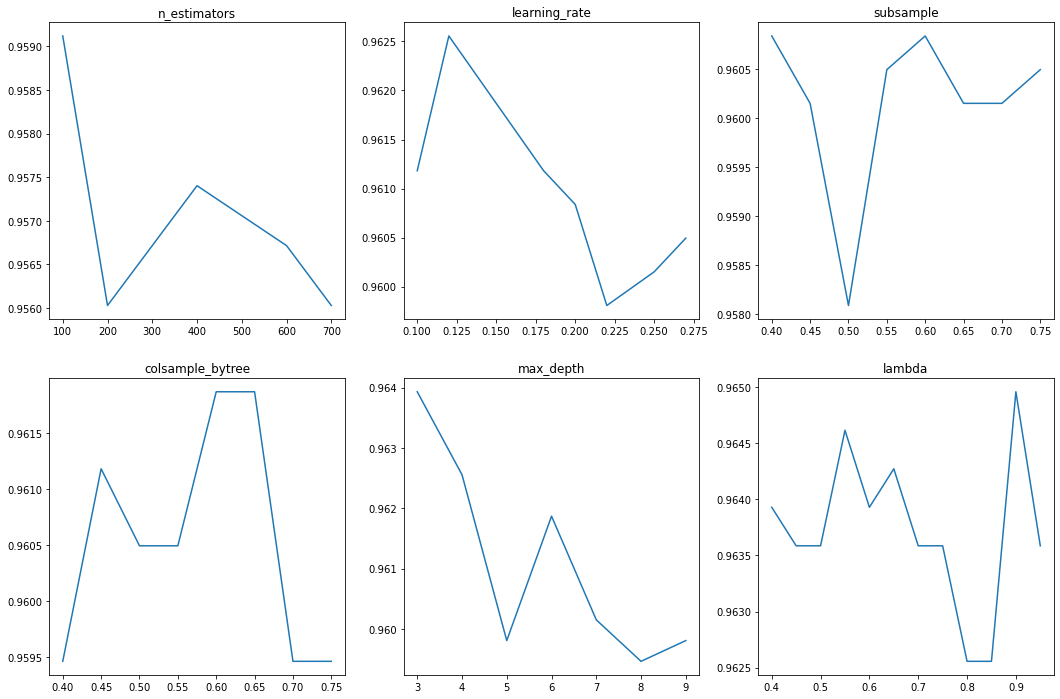

In [292]:
#define hyperparameters
estimators = list(range(100,800,100))
e_p = []
for i in estimators:
    xgbc=xgb.XGBClassifier(n_estimators=i,objective='reg:logistic',use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    e_p.append(accuracy(xgbc))
f=plt.figure(figsize=(18,12))
f.add_subplot(231)
plt.plot(estimators,e_p)
plt.title('n_estimators')
best_e = dict(zip(e_p,estimators))[max(e_p)]
print('estimators finished')

learning_rate = [round(i,2) for i in np.arange(0.1,0.3,0.025)]
learning_rate_p = []
for i in learning_rate:
    xgbc=xgb.XGBClassifier(n_estimators=best_e,learning_rate=i,
                         objective='reg:logistic',use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    learning_rate_p.append(accuracy(xgbc))
f.add_subplot(232)
plt.plot(learning_rate,learning_rate_p)
plt.title('learning_rate')
best_l = dict(zip(learning_rate_p,learning_rate))[max(learning_rate_p)]
print('learning_rate finished')

subsample = [round(i,2) for i in np.arange(0.4,0.8,0.05)]
subsample_p = []
for i in subsample:
    xgbc=xgb.XGBClassifier(n_estimators=best_e,learning_rate=best_l,
                          subsample=i,objective='reg:logistic',use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    subsample_p.append(accuracy(xgbc))
f.add_subplot(233)
plt.plot(subsample,subsample_p)
plt.title('subsample')
best_s = dict(zip(subsample_p,subsample))[max(subsample_p)]
print('subsample finished')

colsample_bytree = [round(i,2) for i in np.arange(0.4,0.8,0.05)]
colsample_bytree_p = []
for i in colsample_bytree:
    xgbc=xgb.XGBClassifier(n_estimators=best_e,learning_rate=best_l,
                          subsample=best_s,colsample_bytree=i,objective='reg:logistic',
                          use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    colsample_bytree_p.append(accuracy(xgbc))
f.add_subplot(234)
plt.plot(colsample_bytree,colsample_bytree_p)
plt.title('colsample_bytree')
best_c = dict(zip(colsample_bytree_p,colsample_bytree))[max(colsample_bytree_p)]
print('colsample_bytree finished')

max_depth = list(range(3,10))
max_depth_p = []
for i in max_depth:
    xgbc=xgb.XGBClassifier(n_estimators=best_e,learning_rate=best_l,
                          subsample=best_s,colsample_bytree=best_c,
                          max_depth=i,objective='reg:logistic',use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    max_depth_p.append(accuracy(xgbc))
f.add_subplot(235)
plt.plot(max_depth,max_depth_p)
plt.title('max_depth')
best_d = dict(zip(max_depth_p,max_depth))[max(max_depth_p)]
print('max_depth finished')

lam = [round(i,2) for i in np.arange(0.4,1,0.05)]
lam_p = []
for i in lam:
    xgbc=xgb.XGBClassifier(n_estimators=best_e,learning_rate=best_l,
                          subsample=best_s,colsample_bytree=best_c,
                          max_depth=best_d,reg_lambda=i,objective='reg:logistic',use_label_encoder=False)
    xgbc.fit(trainx,trainy)
    lam_p.append(accuracy(xgbc))
f.add_subplot(236)
plt.plot(lam,lam_p)
plt.title('lambda')
best_lambda = dict(zip(lam_p,lam))[max(lam_p)]
print('all finished')

In [293]:
#build final model
final_model = xgb.XGBClassifier(objective='reg:logistic',use_label_encoder=False,
                                n_estimators=best_e,learning_rate=best_l,
                                subsample=best_s,colsample_bytree=best_c,
                                max_depth=best_d,reg_lambda=best_lambda)
final_model.fit(trainx,trainy)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.65, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.12, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0.9, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [294]:
#accuracy
np.mean(final_model.predict(testx)==testy)

0.9649604946753693

In [318]:
#fill in dataframe
mldata['Position']=final_model.predict(mldata.drop('return_s',axis=1))
mldata['NAV']=np.exp(np.cumsum(mldata['Position']*mldata['return_s']))

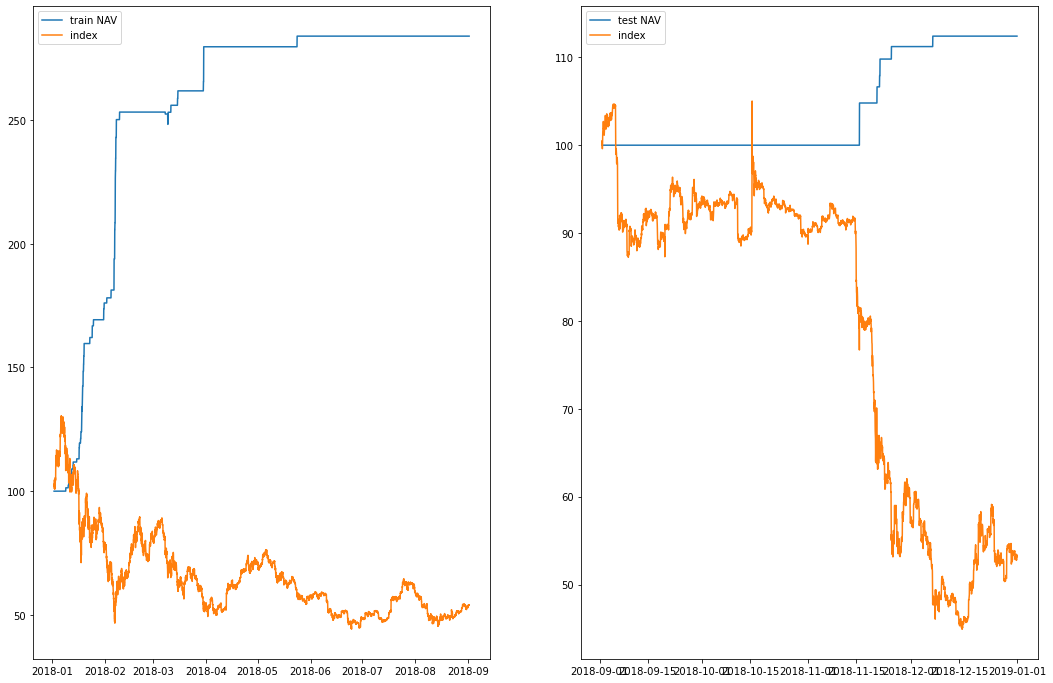

In [558]:
#plot for train and test sample
trainPosition = final_model.predict(trainx)
trainNAV = np.exp(np.cumsum(trainPosition*mldata['return_s'][:t]))
f = plt.figure(figsize=(18,12))
f.add_subplot(121)
plt.plot(trainNAV*100,label='train NAV')
plt.plot(np.exp(np.cumsum(mldata['return_s'][:t]))*100,label='index')
plt.legend()

testPosition = final_model.predict(testx)
testNAV = np.exp(np.cumsum(testPosition*mldata['return_s'][t:]))
f.add_subplot(122)
plt.plot(testNAV*100,label='test NAV')
plt.plot(np.exp(np.cumsum(mldata['return_s'][t:]))*100,label='index')
plt.legend()

<BarContainer object of 12 artists>

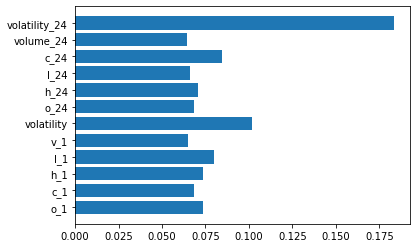

In [326]:
#feature importance plot
plt.barh(['o_1', 'c_1', 'h_1', 'l_1', 'v_1', 'volatility', 'o_24', 'h_24', 'l_24', 'c_24', 
          'volume_24', 'volatility_24'], xgbc.feature_importances_)

In [372]:
#some extra examination
TP = sum(testy[np.where(final_model.predict(testx)==1)[0]]==1)
FP = sum(testy[np.where(final_model.predict(testx)==1)[0]]!=1)
TN = sum(testy[np.where(final_model.predict(testx)==0)[0]]==0)
FN = sum(testy[np.where(final_model.predict(testx)==0)[0]]!=0)
recall = TP/(TP+FN)
Precision = TP/(TP+FP)
print('Precision is '+str(Precision))
print('recall is '+str(recall))
pd.DataFrame([[TP,FN],[FP,TN]],index=['T','F'],columns=['PT','PF'])

Precision is 1.0
recall is 0.05555555555555555


,PT,PF
T,6,102
F,0,2803


In [502]:
Position_1 = final_model.predict(mldata.drop('return_s',axis=1))
r_1 = (Position_1*mldata['return_s']).shift(1).fillna(0)
NAV_1 = (np.exp(np.cumsum(r_1))*100)
xgbc_1 = pd.DataFrame(zip(Position_1,r_1,NAV_1),index=r_1.index,columns=['position','return','NAV'])

Position_P =  final_model.predict_proba(mldata.drop('return_s',axis=1))[:,1]
r_P = (Position_P*mldata['return_s']).shift(1).fillna(0)
NAV_P = (np.exp(np.cumsum(r_P))*100)
xgbc_pb = pd.DataFrame(zip(Position_P,r_P,NAV_P),index=r_P.index,columns=['position','return','NAV'])

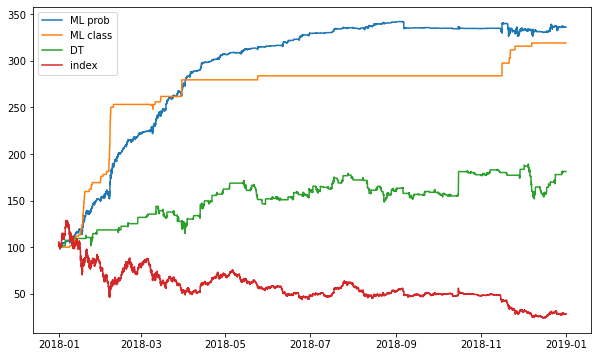

In [431]:
plt.figure(figsize=(10,6))
plt.plot(NAV_P,label='ML prob')
plt.plot(NAV_1,label='ML class')
plt.plot(dt_train['NAV'],label='DT')
plt.plot(h_1['index'],label='index')
plt.legend()

In [549]:
#define report function
def report(df):
    sh = round(sharpe(df),4)
    m_r = np.exp(df.resample('M').agg({'return':'sum'}))-1
    t_r = round(np.exp(sum(df['return']))-1,4)
    maxd = round(maxdrawdown(df['return']),4)
    #count trade related information
    j=0
    trade = []
    for i in range(len(df)-1):
        if(df['position'][i]!=0 and df['position'][i+1]==0):
            trade.append(sum(df['return'][:(i+1)])-sum(df['return'][:j]))
        if(df['position'][i+1]==0):
            j=i+1
    trade = np.array(trade)
    accuracy = round(np.exp(np.mean(trade>0))-1,4)
    count = len(trade)
    freq = round(count/len(df),4)
    avgr = round(np.exp(np.mean(trade))-1,4)
    avgg = round(np.exp(np.mean(trade[trade>0]))-1,4)
    avgl = round(np.exp(np.mean(trade[trade<0]))-1,4)
    maxg = round(np.exp(max(trade[trade>0]))-1,4)
    maxl = round(np.exp(min(trade[trade<0]))-1,4)
    return({'sharpe':sh,'total return':t_r,'accuracy':accuracy,'maxdrawdown':maxd,
           'trade count':count,'trade frequency':freq,'average return':avgr,
           'average gain':avgg,'average loss':avgl,'max gain':maxg,'max loss':maxl,
           'monthly return':m_r})

def preport(df):
    sh = round(sharpe(df),4)
    m_r = np.exp(df.resample('M').agg({'return':'sum'}))-1
    t_r = round(np.exp(sum(df['return']))-1,4)
    maxd = round(maxdrawdown(df['return']),4)
    return({'sharpe':sh,'total return':t_r,'maxdrawdown':maxd,
           'monthly return':m_r})

In [560]:

print('Dual Thaust in sample')
report(dtv1)

Dual Thaust in sample


{'sharpe': 1.4987,
 'total return': 0.8121,
 'accuracy': 0.6712,
 'maxdrawdown': 0.0596,
 'trade count': 111,
 'trade frequency': 0.0127,
 'average return': 0.0054,
 'average gain': 0.0294,
 'average loss': -0.0194,
 'max gain': 0.168,
 'max loss': -0.0928,
 'monthly return':               return
 时间                  
 2018-01-31  0.184572
 2018-02-28  0.113981
 2018-03-31 -0.048636
 2018-04-30  0.292923
 2018-05-31 -0.064329
 2018-06-30  0.059991
 2018-07-31  0.069503
 2018-08-31 -0.065280
 2018-09-30 -0.018415
 2018-10-31  0.125170
 2018-11-30  0.032339
 2018-12-31 -0.012442}

In [544]:
print('XGBoost class in sample')
report(xgbc_1)

XGBoost class in sample


{'sharpe': 5.9275,
 'total return': 2.1918,
 'accuracy': 0.097,
 'maxdrawdown': 0.0165,
 'trade count': 54,
 'trade frequency': 0.0062,
 'average return': 0.0035,
 'average gain': 0.0411,
 'average loss': -0.0129,
 'max gain': 0.066,
 'max loss': -0.0129,
 'monthly return':               return
 时间                  
 2018-01-31  0.760753
 2018-02-28  0.438247
 2018-03-31  0.104246
 2018-04-30  0.000000
 2018-05-31  0.015375
 2018-06-30  0.000000
 2018-07-31  0.000000
 2018-08-31  0.000000
 2018-09-30  0.000000
 2018-10-31  0.000000
 2018-11-30  0.112233
 2018-12-31  0.010696}

In [550]:
print('XGBoost probability in sample')
preport(xgbc_pb)

XGBoost probability in sample


{'sharpe': 5.3549,
 'total return': 2.3614,
 'maxdrawdown': 0.0398,
 'monthly return':               return
 时间                  
 2018-01-31  0.538226
 2018-02-28  0.443138
 2018-03-31  0.240241
 2018-04-30  0.115015
 2018-05-31  0.028964
 2018-06-30  0.043428
 2018-07-31  0.016995
 2018-08-31  0.019274
 2018-09-30 -0.019063
 2018-10-31 -0.001031
 2018-11-30 -0.006452
 2018-12-31  0.010518}

In [506]:
#get out of sample data
datatest = pd.read_csv('C:/Users/23721/my_py_file/BTC/文件2.样本外数据.csv',encoding='gbk')
datatest.head()

,ID,时间,开盘价,收盘价,最高价,最低价,成交额,成交笔数
0,1546272000,2019/1/1 0:00,3754.37,3773.94,3775.86,3752.94,185764.79300,436
1,1546272060,2019/1/1 0:01,3774.74,3758.89,3776.90,3758.89,145890.48720,328
2,1546272120,2019/1/1 0:02,3758.89,3747.36,3758.96,3735.61,188412.27970,489
3,1546272180,2019/1/1 0:03,3747.36,3748.18,3750.32,3744.99,44456.85012,136
4,1546272240,2019/1/1 0:04,3749.64,3749.95,3750.81,3747.68,18888.59050,82


In [507]:
#preparation for out of sample data
datatest.drop('ID',axis=1,inplace=True)
datatest['成交量']=datatest['成交额']/((datatest['收盘价']+datatest['开盘价'])/2)
datatest_m = datatest.copy(deep=True)
get_return(datatest_m)
datatest_m.head()


<ipython-input-51-c48a61665c5e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'][1:]= np.log(df['收盘价'][1:].to_numpy()/df['收盘价'][:-1].to_numpy())
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,时间,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return
1,2019/1/1 0:01,3774.74,3758.89,3776.90,3758.89,145890.48720,328,38.730463,-0.003996
2,2019/1/1 0:02,3758.89,3747.36,3758.96,3735.61,188412.27970,489,50.201440,-0.003072
3,2019/1/1 0:03,3747.36,3748.18,3750.32,3744.99,44456.85012,136,11.862214,0.000219
4,2019/1/1 0:04,3749.64,3749.95,3750.81,3747.68,18888.59050,82,5.037233,0.000472
5,2019/1/1 0:05,3750.18,3746.13,3750.20,3745.09,85799.40406,139,22.891104,-0.001019


In [523]:
#more preparation
datatest_h = datatest_m.copy()
datatest_h['时间']=pd.to_datetime(datatest_h['时间'])
datatest_h = datatest_h.set_index('时间')
datatest_h['volatility'] = datatest_h['return']
datatest_h = datatest_h.resample('H').agg(aggregation)
datatest_h['index']=np.exp(np.cumsum(datatest_h['return']))*100
datatest_h.head()

,开盘价,收盘价,最高价,最低价,成交额,成交笔数,成交量,return,volatility,index
时间,,,,,,,,,,
2019-01-01 00:00:00,3774.74,3736.26,3776.90,3725.19,2.635934e+06,4615,704.405412,-0.010034,0.000907,99.001574
2019-01-01 01:00:00,3736.27,3737.48,3741.94,3721.95,3.194000e+06,3180,855.024850,0.000326,0.000726,99.033901
2019-01-01 02:00:00,3738.37,3743.36,3748.94,3733.38,2.831638e+06,1817,757.081327,0.001572,0.000355,99.189706
2019-01-01 03:00:00,3741.82,3685.93,3744.98,3650.00,6.643572e+06,8026,1797.015566,-0.015461,0.002043,97.667954
2019-01-01 04:00:00,3685.94,3672.74,3689.96,3656.17,3.886411e+06,3754,1057.528715,-0.003585,0.001161,97.318452


In [551]:
#test Dual Thrust strategy
dt_t = dt_v1(datatest_h,k1=0.3,k2=0.3,k3=0.02,n=48)
print('Dual Thrust out of sample')
report(dt_t)

Dual Thrust out of sample


{'sharpe': 1.0447,
 'total return': 0.2828,
 'accuracy': 0.5036,
 'maxdrawdown': 0.0766,
 'trade count': 76,
 'trade frequency': 0.0177,
 'average return': 0.0033,
 'average gain': 0.0265,
 'average loss': -0.0124,
 'max gain': 0.1072,
 'max loss': -0.0605,
 'monthly return':               return
 时间                  
 2019-01-31 -0.112918
 2019-02-28  0.152754
 2019-03-31  0.007672
 2019-04-30  0.126256
 2019-05-31  0.095170
 2019-06-30  0.009280}

In [552]:
#test for ML model
ml_h = h_24(datatest_h)
Position_t = final_model.predict(ml_h.drop(['index','return_s'],axis=1))
r_t = (Position_t*ml_h['return_s']).shift(1).fillna(0)
NAV_t = (np.exp(np.cumsum(r_t))*100)
xgbc_t = pd.DataFrame(zip(Position_t,r_t,NAV_t),index=r_t.index,columns=['position','return','NAV'])
print('XGBoost class out of sample')
report(xgbc_t)

XGBoost class out of sample


{'sharpe': -0.702,
 'total return': -0.0307,
 'accuracy': 0.1175,
 'maxdrawdown': 0.0388,
 'trade count': 9,
 'trade frequency': 0.0021,
 'average return': 0.0012,
 'average gain': 0.0476,
 'average loss': -0.0118,
 'max gain': 0.0476,
 'max loss': -0.0223,
 'monthly return':               return
 时间                  
 2019-01-31  0.000000
 2019-02-28  0.000000
 2019-03-31  0.000000
 2019-04-30  0.000000
 2019-05-31  0.000000
 2019-06-30 -0.030654}

In [ ]:
#ML model (probability)
Position_tp = final_model.predict_proba(ml_h.drop(['index','return_s'],axis=1))[:,1]
r_tp = (Position_tp*ml_h['return_s']).shift(1).fillna(0)
NAV_tp = (np.exp(np.cumsum(r_tp))*100)
xgbc_tp = pd.DataFrame(zip(Position_tp,r_tp,NAV_tp),index=r_t.index,columns=['position','return','NAV'])
xgbc_tp.tail()

In [553]:
print('XGBoost prob out of sample')
preport(xgbc_tp)

XGBoost prob out of sample


{'sharpe': 0.0665,
 'total return': 0.0195,
 'maxdrawdown': 0.0355,
 'monthly return':               return
 时间                  
 2019-01-31 -0.003896
 2019-02-28  0.004327
 2019-03-31  0.000576
 2019-04-30  0.005252
 2019-05-31  0.020642
 2019-06-30 -0.007354}

Text(0.5, 1.0, 'out of sample')

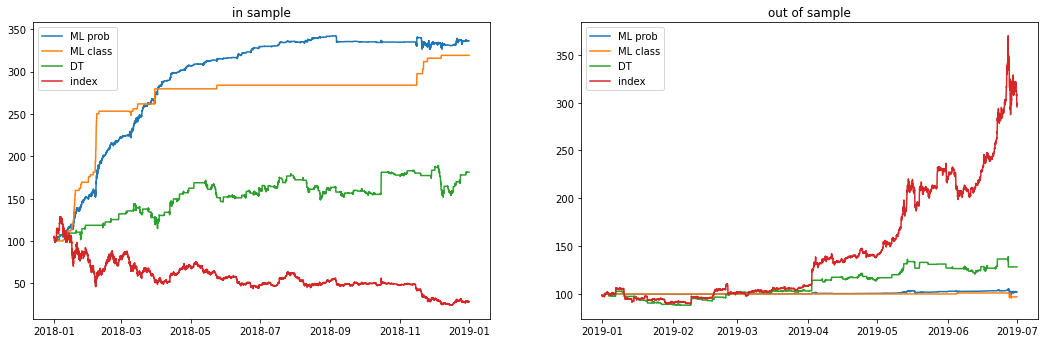

In [531]:
#plot for all strategy in sample and out of sample
f = plt.figure(figsize=(18,12))
f.add_subplot(221)
plt.plot(NAV_P,label='ML prob')
plt.plot(NAV_1,label='ML class')
plt.plot(dt_train['NAV'],label='DT')
plt.plot(h_1['index'],label='index')
plt.legend()
plt.title('in sample')

f.add_subplot(222)
plt.plot(NAV_tp,label='ML prob')
plt.plot(NAV_t,label='ML class')
plt.plot(dt_t['NAV'],label='DT')
plt.plot(datatest_h['index'],label='index')
plt.legend()
plt.title('out of sample')

{'mean': 0.00024947304426671426, 'median': 0.0001985023190140903, 'std': 0.006625741918307343, 'skewness': -0.4071825880343212, 'kurtosis': 26.430372454886356}


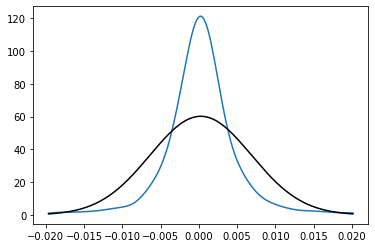

In [555]:
#out of sample data distribution
statistics(datatest_h['return'])